<a href="https://colab.research.google.com/github/yifeili6/DL_BP_tutorial/blob/main/tutorial_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ESM2**
reference: https://huggingface.co/docs/transformers/main/en/model_doc/esm#transformers.EsmTokenizer

In [4]:
!pip install transformers
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Pretrained model

### Masked aa prediction from pre-trained model

In [60]:
'''
Tokenize a protein sequence with masked amino acid
'''

# Example protein sequence with a masked amino acid
# <mask>: a masked amino acid
protein_sequence = ["MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIA<mask>LRSLGYNIVATPRGYVLAGG"]

# Initialize the pretrained-tokenizer
tokenizer = AutoTokenizer.from_pretrained('facebook/esm2_t12_35M_UR50D')
print(tokenizer.__dict__['_id_to_token'], '\n')

# Tokenize the sequence
inputs = tokenizer(protein_sequence, return_tensors='pt')
print(inputs)


{0: '<cls>', 1: '<pad>', 2: '<eos>', 3: '<unk>', 4: 'L', 5: 'A', 6: 'G', 7: 'V', 8: 'S', 9: 'E', 10: 'R', 11: 'T', 12: 'I', 13: 'D', 14: 'P', 15: 'K', 16: 'Q', 17: 'N', 18: 'F', 19: 'Y', 20: 'M', 21: 'H', 22: 'W', 23: 'C', 24: 'X', 25: 'B', 26: 'U', 27: 'Z', 28: 'O', 29: '.', 30: '-', 31: '<null_1>', 32: '<mask>'} 

{'input_ids': tensor([[ 0, 20, 15, 11,  7, 10, 16,  9, 10,  4, 15,  8, 12,  7, 10, 12,  4,  9,
         10,  8, 15,  9, 14,  7,  8,  6,  5, 16,  4,  5,  9,  9,  4,  8,  7,  8,
         10, 16,  7, 12,  7, 16, 13, 12,  5, 32,  4, 10,  8,  4,  6, 19, 17, 12,
          7,  5, 11, 14, 10,  6, 19,  7,  4,  5,  6,  6,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [58]:
# retrieve index of <mask>
mask_token_index = torch.where(inputs.input_ids == tokenizer.mask_token_id)
mask_token_index

(tensor([0]), tensor([45]))

In [38]:
'''
Use pretrained model to predict masked amino acid
'''

# Initialize pretrained-model
model     = AutoModelForMaskedLM.from_pretrained('facebook/esm2_t12_35M_UR50D')

# Get the model's output
with torch.no_grad():
  outputs = model(**inputs)

print(outputs)


MaskedLMOutput(loss=None, logits=tensor([[[ 16.5645,  -5.3424,   0.5486,  ..., -15.0847, -14.9969,  -5.4086],
         [ -7.1304, -14.1802,  -9.1433,  ..., -15.2171, -15.0340, -14.1953],
         [-13.0124, -20.1416, -13.2222,  ..., -16.2488, -16.2415, -20.1353],
         ...,
         [-13.1841, -19.0534, -12.4284,  ..., -16.1395, -16.1348, -19.0685],
         [-11.6565, -16.8951, -10.2605,  ..., -15.8658, -15.8133, -16.9078],
         [ -0.2080,  -5.8248,  17.6467,  ..., -15.5455, -15.9118,  -5.8538]]]), hidden_states=None, attentions=None)


torch.Size([2, 67, 33])


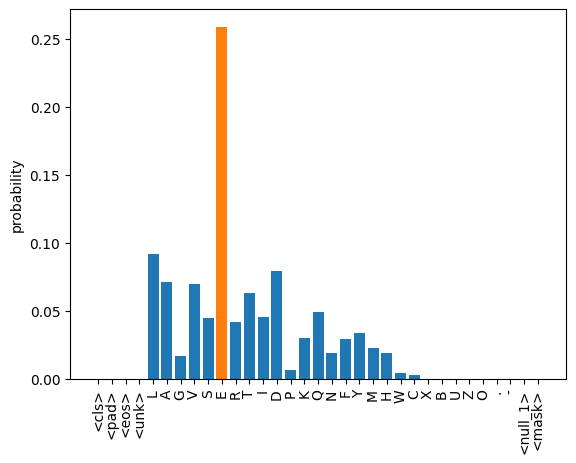

In [96]:
'''
plot the predicted result
'''
# plot the prediction of masked amino acid
print(outputs.logits.shape) # (torch.FloatTensor of shape (batch_size, sequence_length, config.vocab_size)) — Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax).

plt.bar(range(len(tokenizer.__dict__['_id_to_token'].values())),
        outputs.logits[mask_token_index].softmax(dim = -1).detach().numpy()[0])
max_index = torch.argmax(outputs.logits[mask_token_index])
plt.bar(max_index,
        outputs.logits[mask_token_index].softmax(dim = -1).detach().numpy()[0][max_index])
plt.xticks(range(len(tokenizer.__dict__['_id_to_token'].values())),
           tokenizer.__dict__['_id_to_token'].values(), rotation=90)
plt.ylabel('probability')
plt.show()

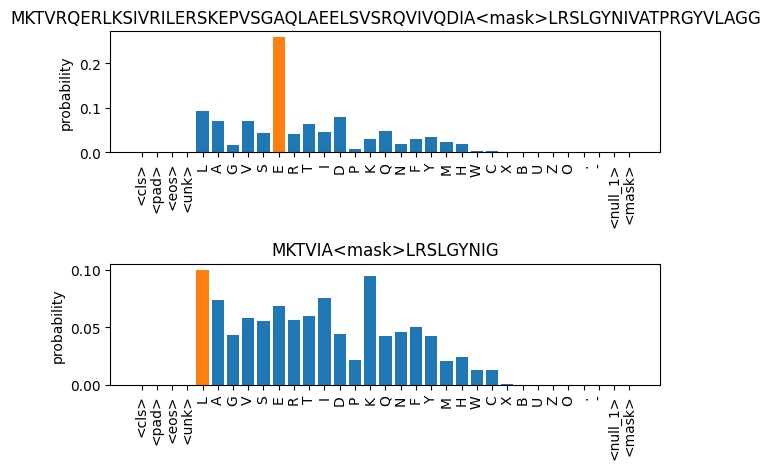

In [117]:
'''
Tokenize MORE THAN ONE protein sequence with masked amino acid
Here, different protein squence have different length, we need to use padding
'''

# Example two protein sequences with a masked amino acid
protein_sequence = ["MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIA<mask>LRSLGYNIVATPRGYVLAGG",
                    "MKTVIA<mask>LRSLGYNIG"]

# Encode the sequence
'''NOTE THAT WE USED PADDING HERE'''
inputs = tokenizer.batch_encode_plus(protein_sequence,
                                     padding=True,
                                     return_tensors='pt')

# Retrieve index of <mask>
mask_token_index = torch.where(inputs.input_ids == tokenizer.mask_token_id)

# Get the model's output
with torch.no_grad():
  outputs = model(**inputs)

fig, ax = plt.subplots(len(protein_sequence), 1,  sharex=False)
for i, v in enumerate(protein_sequence):
  ax.flatten()[i].bar(range(len(tokenizer.__dict__['_id_to_token'].values())),
                      outputs.logits[mask_token_index[0][i], mask_token_index[1][i]].softmax(dim = -1).detach().numpy())
  max_index = torch.argmax(outputs.logits[mask_token_index[0][i], mask_token_index[1][i]])
  ax.flatten()[i].bar(max_index,
                      outputs.logits.softmax(dim = -1)[mask_token_index][i][max_index].detach().numpy())
  ax.flatten()[i].set_xticks(range(len(tokenizer.__dict__['_id_to_token'].values())),
                            tokenizer.__dict__['_id_to_token'].values(), rotation=90)
  ax.flatten()[i].set_ylabel('probability')
  ax.flatten()[i].set_title(v)
plt.tight_layout()
plt.show()
